In [1]:
import json

import numpy as np
import deepdish as dd
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from typing import List
from pathlib import Path, PosixPath

%matplotlib inline

ListOfLists = List[List]

def polygons_to_mask_array(polygons : ListOfLists, width : int = 300, height : int = 300) -> np.ndarray:
    '''
    This function takes a list of lists that contains polygon masks for each building. Example;
    
    [[x11,y11,x12,y12,...],...,[xn1,yn1,xn2,yn2,...]]
    
    The return of this function is an array of size width x height which contains a binary mask
    as defined by the list of polygons. This will be the target for our network!
    '''
    
    img = Image.new('L', (width, height), 0)    
    for polygon in polygons:
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    mask = np.array(img)
    
    return mask

def mask_array_to_polygons(mask_array : np.ndarray) -> ListOfLists:
    '''
    This function does the inverse of polygons_to_mask_array. Given a mask array it
    will return a list of lists that represents the polygon of each distinguishable 
    building int the mask. It is able to distinguis building with an x/y seperation of at least 
    2 pixels anything closer will be returned as a merged polygon
    '''
    
    contours = cv.findContours(y,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    polygons = contours[1]
    polygons = [list(polygon.reshape(polygon.shape[0],2).flatten()) for polygon in polygons]
    return polygons

In [2]:
# lets get some locations down
data_dir = Path('../data')
test_dir = data_dir / Path('test')
train_dir = data_dir / Path('train')
val_dir = data_dir / Path('val')

train_an_path = list(train_dir.glob('*.json'))[1]
val_an_path = list(val_dir.glob('*.json'))[1]

# restricting number of ims to load for testing purposes
train_ims_fnames = list((train_dir / Path('images')).glob('*.jpg'))
test_ims_fnames = list(test_dir.glob('*.jpg'))
val_ims_fnames = list((val_dir / Path('images')).glob('*.jpg'))

In [3]:
# This take like for fucking ever!! Perhaps combine this with creation of hdf5 file? Lazy evaluation...
train_ims = ((int(x.name.split('.')[0]),cv.imread(str(x))) for x in train_ims_fnames)
val_ims = ((int(x.name.split('.')[0]),cv.imread(str(x))) for x in val_ims_fnames)
test_ims = ((int(x.name.split('.')[0]),cv.imread(str(x))) for x in test_ims_fnames)

In [4]:
# for each image annotation produce mask array

def an_json_to_masks(an_path : PosixPath) -> pd.DataFrame:

    grouped = pd.DataFrame(json.loads(an_path.read_text())['annotations']).groupby('image_id')
    grouped = grouped.agg({'segmentation' : lambda x : [z[0] for z in x]})
    grouped_idx = grouped.index
    grouped_vals = [list(x)[0] for x in grouped.values]

    grouped = list(zip(grouped_idx,grouped_vals))
    
    return [(id_,polygons_to_mask_array(ann)) for id_,ann in grouped]

train_masks = sorted(an_json_to_masks(train_an_path), key = lambda x : x[0])
val_masks = sorted(an_json_to_masks(val_an_path), key = lambda x : x[0])

In [ ]:
N_train = len(train_masks)
N_val = len(val_masks)
N_test = len(test_ims_fnames)

# this will now take fucking forever
d_train = {
    'sample_{}'.format(i): {
        'im':im[1],
        'mask':mask[1],
    } for i,im,mask in zip(range(N_train),train_ims,train_masks)
}

d_val = {
    'sample_{}'.format(i): {
        'im':im[1],
        'mask':mask[1],
    } for i,im,mask in zip(range(N_val),val_ims,val_masks)
}

d_test ={
    'sample_{}'.format(i) : {
        'im':im[1]
    } for i,im in zip(range(N_test),)
}

# this to probably
dd.io.save('train.h5',d_train) 
dd.io.save('val.h5',d_val)
dd.io.save('test.h5',d_test)

In [ ]:
plt.imshow(dd.io.load('train.h5','/sample_101/im'))
plt.imshow(dd.io.load('train.h5','/sample_101/mask'),alpha=0.5)

x = [[0, 0, 0, 40, 40, 40, 40, 0], [0, 42, 0, 82, 40, 82, 40, 42]], z = [[0, 42, 0, 82, 40, 82, 40, 42], [0, 0, 0, 40, 40, 40, 40, 0]]


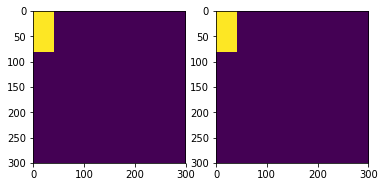

In [2]:
x = [[0,0,0,40,40,40,40,0], [0,42,0,82,40,82,40,42]]
y = polygons_to_mask_array(x)
z = mask_array_to_polygons(y)
w = polygons_to_mask_array(z)

fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(y)
ax[1].imshow(w)

print(f'x = {x}, z = {z}')

x = [[0, 0, 0, 40, 40, 40, 40, 0], [0, 41, 0, 81, 40, 81, 40, 41]], z = [[0, 0, 0, 81, 40, 81, 40, 0]]


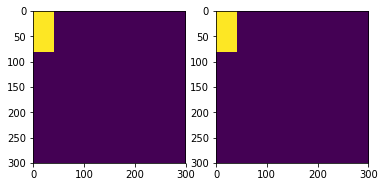

In [3]:
x = [[0,0,0,40,40,40,40,0], [0,41,0,81,40,81,40,41]]
y = polygons_to_mask_array(x)
z = mask_array_to_polygons(y)
w = polygons_to_mask_array(z)

fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(y)
ax[1].imshow(w)

print(f'x = {x}, z = {z}')

x = [[0, 0, 0, 40, 40, 40, 40, 0], [42, 0, 42, 40, 82, 40, 82, 0]], z = [[42, 0, 42, 40, 82, 40, 82, 0], [0, 0, 0, 40, 40, 40, 40, 0]]


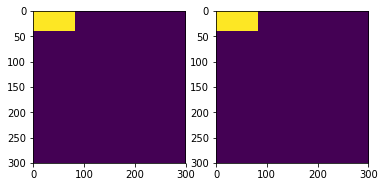

In [4]:
x = [[0,0,0,40,40,40,40,0], [42,0,42,40,82,40,82,0]]
y = polygons_to_mask_array(x)
z = mask_array_to_polygons(y)
w = polygons_to_mask_array(z)

fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(y)
ax[1].imshow(w)

print(f'x = {x}, z = {z}')

x = [[0, 0, 0, 40, 40, 40, 40, 0], [41, 0, 41, 40, 81, 40, 81, 0]], z = [[0, 0, 0, 40, 81, 40, 81, 0]]


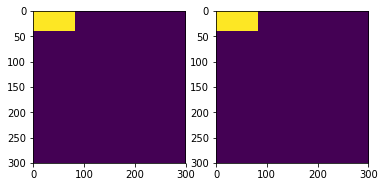

In [5]:
x = [[0,0,0,40,40,40,40,0], [41,0,41,40,81,40,81,0]]
y = polygons_to_mask_array(x)
z = mask_array_to_polygons(y)
w = polygons_to_mask_array(z)

fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(y)
ax[1].imshow(w)

print(f'x = {x}, z = {z}')

- As long as polygons are 2 pixels away from each other then opencv can distiguish between them!

In [ ]:
# want to make 3 hdf files train, val, test
# Each of train and val will have the following;
#
# - image_id
# - original_path_to_image
# - image 300x300x3
# - mask 300x300x1
# - json blob for all annotations
# 
# train wil just have;
#
# - image_id
# - original_path_to_image
# - image 300x300x3

